# 🧬 Phase 5: Protein Language Model Classification

## 📋 Goal
Train a classifier to predict subfamily labels for sequences currently labeled as 'OtherClassA'

## 🔧 Key Fixes Applied
1. ✅ Use **full-length sequences** (not C-terminal tails)
2. ✅ Handle **class imbalance** with proper techniques
3. ✅ Better **error handling** for embedding generation
4. ✅ Clear **explanations** throughout

## 📊 Data Flow
```
Labeled Sequences (Known subfamily) 
    ↓
ESM-2 Embeddings (1280-dim vectors)
    ↓
Train Random Forest Classifier
    ↓
Predict 'OtherClassA' → Assign correct subfamily
```

---
## 1️⃣ Import Libraries

In [44]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

# Deep learning (for ESM-2)
try:
    import torch
    print(f"✓ PyTorch: {torch.__version__}")
    print(f"✓ CUDA available: {torch.cuda.is_available()}")
except ImportError:
    print("⚠️  PyTorch not found. Install: pip install torch")

# Plotting config
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("\n✓ All libraries loaded successfully!")

✓ PyTorch: 2.10.0+cpu
✓ CUDA available: False

✓ All libraries loaded successfully!


---
## 2️⃣ Install ESM-2 (if needed)

In [45]:
# ESM (Evolutionary Scale Modeling) - Facebook Research protein language model
try:
    import esm
    print("✓ ESM already installed")
except ImportError:
    print("Installing ESM...")
    !pip install fair-esm
    import esm
    print("✓ ESM installed successfully")

✓ ESM already installed


---
## 3️⃣ Load Data

### Data Structure:
- **Labeled data**: Sequences with known subfamily (for training)
- **Unlabeled data**: Sequences marked as 'OtherClassA' (for prediction)

In [52]:
print("="*80)
print("📂 LOADING DATA")
print("="*80)

# Load labeled sequences (for training)
# IMPORTANT: Use sequences_labeled_full.csv (FULL sequences, not tails!)
df_full = pd.read_csv('../data/processed/sequences_labeled_full.csv')

# Separate labeled (known subfamily) vs unlabeled (OtherClassA)
df_labeled = df_full[df_full['subfamily'] != 'Other_ClassA'].copy()
df_unlabeled = df_full[df_full['subfamily'] == 'Other_ClassA'].copy()

# ADD THESE TWO LINES:
df_labeled['sequence'] = df_labeled['sequence'].str.upper()  # Convert to uppercase
df_unlabeled['sequence'] = df_unlabeled['sequence'].str.upper()  # Convert to uppercase

print(f"\n📊 Data Summary:")
print(f"   • Total sequences: {len(df_full)}")
print(f"   • Labeled (for training): {len(df_labeled)}")
print(f"   • Unlabeled (to predict): {len(df_unlabeled)}")

print(f"\n🏷️  Subfamily Distribution (Labeled):")
print(df_labeled['subfamily'].value_counts())

print(f"\n📏 Sequence Length Statistics:")
print(df_labeled['sequence'].str.len().describe())

# Check for suspiciously short sequences
min_length = df_labeled['sequence'].str.len().min()
if min_length < 100:
    print(f"\n⚠️  WARNING: Shortest sequence is only {min_length} amino acids!")
    print("   This suggests C-terminal tails, not full sequences.")
    print("   ESM-2 needs longer sequences for good embeddings.")

📂 LOADING DATA

📊 Data Summary:
   • Total sequences: 1998
   • Labeled (for training): 515
   • Unlabeled (to predict): 1483

🏷️  Subfamily Distribution (Labeled):
subfamily
Adrenergic_beta     372
Adrenergic_alpha     53
Dopamine             35
Histamine            31
Serotonin            23
Muscarinic            1
Name: count, dtype: int64

📏 Sequence Length Statistics:
count    515.000000
mean     423.990291
std       13.219264
min      413.000000
25%      414.000000
50%      419.000000
75%      430.000000
max      471.000000
Name: sequence, dtype: float64


### 🔍 Data Quality Check

In [53]:
# Show example sequences to verify they're FULL length
print("\n🔬 Sample Sequences:")
for idx, row in df_labeled.head(3).iterrows():
    seq = row['sequence']
    print(f"\n{row['subfamily']} ({len(seq)} aa):")
    print(f"   {seq[:50]}...{seq[-50:]}")
    
# Check for gaps (dashes)
has_gaps = df_labeled['sequence'].str.contains('-').sum()
if has_gaps > 0:
    print(f"\n⚠️  {has_gaps} sequences contain gaps (-)")
    print("   Removing gaps before embedding generation...")
    df_labeled['sequence'] = df_labeled['sequence'].str.replace('-', '')
    df_unlabeled['sequence'] = df_unlabeled['sequence'].str.replace('-', '')


🔬 Sample Sequences:

Adrenergic_beta (413 aa):
   MGQPGNGSAFLLAPNGSHAPDHDVTQERDEVWVVGMGIVMSLIVLAIVFG...SGYHVEQEKENKLLCEDLPGTEDFVGHQGTVPSDNIDSQGRNCSTNDSLL

Adrenergic_beta (416 aa):
   MGQPGNSSDFLLASNGSHAPDHNVTQERDEAWVVGMAIVMSLIVLAIVFG...SGYHLGQEKESKLLCEEPPGTEDFVNCQGTVPSDSIDSQGRNCSTNDSLL

Adrenergic_beta (418 aa):
   MGQPGNDSDFLLAPNGSQAPGHDITQERDEAWVVGMAMVMSLIVLATVFG...SGCHLGQEKESELLCEDPPGMEGFVNCQGTVPSDSIDSQGRNCSTNDSLL

⚠️  497 sequences contain gaps (-)
   Removing gaps before embedding generation...


---
## 4️⃣ Load ESM-2 Model

### What is ESM-2?
- **Protein language model** trained on 65 million protein sequences
- Converts protein sequences → **meaningful numerical vectors** (embeddings)
- Similar to how GPT understands text, ESM-2 understands proteins

### Model Size:
- Using **ESM-2 650M** (650 million parameters)
- Embedding dimension: **1280** numbers per sequence
- Good balance of accuracy vs speed

In [54]:
print("="*80)
print("🤖 LOADING ESM-2 MODEL")
print("="*80)

import torch
import esm

print("\nDownloading ESM-2 650M model...")
print("(First time only - downloads ~2.5 GB)\n")

# Load pre-trained model
model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
batch_converter = alphabet.get_batch_converter()
model.eval()  # Set to evaluation mode (disable dropout)

# Use GPU if available (much faster!)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(f"✓ Model loaded successfully")
print(f"   • Device: {device}")
print(f"   • Embedding dimension: {model.embed_dim}")
print(f"   • Number of layers: {model.num_layers}")
print(f"   • Max sequence length: 1024 amino acids")

🤖 LOADING ESM-2 MODEL

(First time only - downloads ~2.5 GB)

✓ Model loaded successfully
   • Device: cpu
   • Embedding dimension: 1280
   • Number of layers: 33
   • Max sequence length: 1024 amino acids


---
## 5️⃣ Define Embedding Function

### How it works:
1. **Input**: Protein sequence (string of amino acids)
2. **Process**: Feed through ESM-2's 33 layers
3. **Output**: 1280-dimensional vector (embedding)
4. **Pool**: Average all positions → single vector per sequence

In [55]:
def get_embedding(sequence, model, batch_converter, device, verbose=False):
    """
    Generate ESM-2 embedding for a protein sequence.
    
    Args:
        sequence (str): Protein sequence (amino acids)
        model: ESM-2 model
        batch_converter: ESM batch converter
        device: torch device (cuda/cpu)
        verbose (bool): Print debug info
    
    Returns:
        numpy array: 1280-dimensional embedding vector
    
    Raises:
        ValueError: If sequence is too short or invalid
    """
    # Validate sequence
    if len(sequence) < 10:
        raise ValueError(f"Sequence too short ({len(sequence)} aa)")
    
    # Remove gaps and invalid characters
    sequence = sequence.replace('-', '').replace('*', '')
    
    # Truncate if too long (ESM-2 max = 1024)
    if len(sequence) > 1022:  # Leave room for special tokens
        if verbose:
            print(f"   Truncating sequence from {len(sequence)} → 1022 aa")
        sequence = sequence[:1022]
    
    # Prepare data
    data = [("protein", sequence)]
    batch_labels, batch_strs, batch_tokens = batch_converter(data)
    batch_tokens = batch_tokens.to(device)
    
    # Generate embeddings (no gradient calculation needed)
    with torch.no_grad():
        results = model(batch_tokens, repr_layers=[33])  # Last layer
        embeddings = results["representations"][33]
    
    # Mean pooling (exclude special start/end tokens)
    # Shape: [batch=1, length, embed_dim=1280] → [1280]
    embedding = embeddings[0, 1:-1].mean(dim=0)
    
    return embedding.cpu().numpy()

print("✓ Embedding function defined")
print("\n📝 Function signature:")
print("   Input:  Protein sequence (str)")
print("   Output: 1280-dimensional vector (numpy array)")

✓ Embedding function defined

📝 Function signature:
   Input:  Protein sequence (str)
   Output: 1280-dimensional vector (numpy array)


---
## 6️⃣ Generate Embeddings - LABELED DATA

### This step:
- Converts each labeled sequence → 1280 numbers
- Takes **~5 seconds per sequence** on CPU
- With GPU: ~1 second per sequence

### Progress tracker:
- Shows successful vs failed embeddings
- Saves results incrementally

In [56]:
print("="*80)
print("🔄 GENERATING EMBEDDINGS - LABELED DATA")
print("="*80)

n_total = len(df_labeled)
print(f"\n📊 Processing {n_total} labeled sequences...")
print(f"   Estimated time: ~{n_total * 5 // 60} minutes on CPU\n")

# Storage
embeddings_list = []
valid_indices = []
failed_count = 0
failed_reasons = {}

# Progress tracking
for i, (idx, row) in enumerate(df_labeled.iterrows()):
    try:
        # Generate embedding
        sequence = row['sequence']
        embedding = get_embedding(sequence, model, batch_converter, device)
        
        # Save
        embeddings_list.append(embedding)
        valid_indices.append(idx)
        
        # Progress update
        if (i + 1) % 20 == 0 or (i + 1) == n_total:
            print(f"   Processed {i + 1}/{n_total} sequences")
        
    except Exception as e:
        failed_count += 1
        reason = str(e)[:30]
        failed_reasons[reason] = failed_reasons.get(reason, 0) + 1
        
        if failed_count <= 5:  # Show first 5 errors
            print(f"\n⚠️  Failed #{failed_count}: {row.get('id', idx)}")
            print(f"   Reason: {reason}")
            print(f"   Sequence length: {len(row['sequence'])} aa")

# Convert to array
embeddings_array = np.array(embeddings_list)

# Filter dataframe
df_labeled_valid = df_labeled.loc[valid_indices].reset_index(drop=True)

# Results
print(f"\n" + "="*80)
print("✅ EMBEDDING GENERATION COMPLETE")
print("="*80)
print(f"   • Successful: {len(embeddings_list)} / {n_total} ({len(embeddings_list)/n_total*100:.1f}%)")
print(f"   • Failed: {failed_count}")
print(f"   • Embedding shape: {embeddings_array.shape}")

if failed_reasons:
    print(f"\n❌ Failure reasons:")
    for reason, count in sorted(failed_reasons.items(), key=lambda x: -x[1]):
        print(f"   • {reason}: {count} sequences")

# Check class distribution after embedding
print(f"\n🏷️  Valid Sequences by Subfamily:")
print(df_labeled_valid['subfamily'].value_counts())

🔄 GENERATING EMBEDDINGS - LABELED DATA

📊 Processing 515 labeled sequences...
   Estimated time: ~42 minutes on CPU

   Processed 20/515 sequences
   Processed 40/515 sequences
   Processed 60/515 sequences
   Processed 80/515 sequences
   Processed 100/515 sequences
   Processed 120/515 sequences
   Processed 140/515 sequences
   Processed 160/515 sequences
   Processed 180/515 sequences
   Processed 200/515 sequences
   Processed 220/515 sequences
   Processed 240/515 sequences
   Processed 260/515 sequences
   Processed 280/515 sequences
   Processed 300/515 sequences
   Processed 320/515 sequences
   Processed 340/515 sequences
   Processed 360/515 sequences
   Processed 380/515 sequences
   Processed 400/515 sequences
   Processed 420/515 sequences
   Processed 440/515 sequences
   Processed 460/515 sequences
   Processed 480/515 sequences
   Processed 500/515 sequences
   Processed 515/515 sequences

✅ EMBEDDING GENERATION COMPLETE
   • Successful: 515 / 515 (100.0%)
   • Failed:

### ⚠️ Important Check

If you see:
- **High failure rate (>50%)**: Sequences are probably C-terminal tails, not full proteins
- **Only 1-2 classes**: Model won't learn well - need more diverse training data
- **"Sequence too short" errors**: Confirm you're using `sequences_labeled_full.csv`

---
## 7️⃣ Train Classifier

### Random Forest Classifier:
- **Input**: 1280-dimensional embeddings
- **Output**: Subfamily prediction
- **Method**: Ensemble of 100 decision trees

### Class Balancing:
- `class_weight='balanced'` → Give more weight to minority classes
- Prevents model from only predicting the largest class

In [71]:
print("="*80)
print("🎯 TRAINING CLASSIFIER")
print("="*80)

# 1. Count occurrences
class_counts = df_labeled_valid['subfamily'].value_counts()

# 2. Identify classes with at least 2 members
valid_classes = class_counts[class_counts >= 2].index

# 3. Filter the dataframe
df_filtered = df_labeled_valid[df_labeled_valid['subfamily'].isin(valid_classes)].copy()

# 4. Re-prepare your X and y from the filtered dataframe
# Note: Ensure your embeddings_array is filtered to match the same indices
X = embeddings_array[df_filtered.index] 
y = df_filtered['subfamily'].values

# Now proceed with LabelEncoder and train_test_split
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# # Prepare features (X) and labels (y)
# X = embeddings_array
# y = df_labeled_valid['subfamily'].values

# # Encode labels to numbers
# le = LabelEncoder()
# y_encoded = le.fit_transform(y)

print(f"\n📊 Training Data:")
print(f"   • Features (X): {X.shape}")
print(f"   • Labels (y): {y.shape}")
print(f"   • Classes: {list(le.classes_)}")

# Class distribution
print(f"\n🏷️  Class Distribution:")
unique, counts = np.unique(y_encoded, return_counts=True)
for cls, count in zip(le.classes_, counts):
    print(f"   • {cls}: {count} sequences ({count/len(y)*100:.1f}%)")

# Check for class imbalance
max_count = counts.max()
min_count = counts.min()
imbalance_ratio = max_count / min_count
if imbalance_ratio > 3:
    print(f"\n⚠️  Class imbalance detected! Ratio: {imbalance_ratio:.1f}:1")
    print("   Using balanced class weights to compensate.")



# Train/test split (stratified to maintain class distribution)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

print(f"\n📊 Split:")
print(f"   • Training: {len(X_train)} sequences")
print(f"   • Testing: {len(X_test)} sequences")

# Train Random Forest with class balancing
print(f"\n🌲 Training Random Forest...")
rf_clf = RandomForestClassifier(
    n_estimators=100,          # 100 decision trees
    random_state=42,           # Reproducibility
    n_jobs=-1,                 # Use all CPU cores
    class_weight='balanced',   # 🔥 Balance classes!
    max_depth=20,              # Limit tree depth
    min_samples_split=5,       # Min samples to split node
    min_samples_leaf=2         # Min samples in leaf
)

rf_clf.fit(X_train, y_train)

# Evaluate
y_pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"\n✅ Training Complete!")
print(f"   • Test Accuracy: {accuracy*100:.2f}%")

🎯 TRAINING CLASSIFIER

📊 Training Data:
   • Features (X): (514, 1280)
   • Labels (y): (514,)
   • Classes: ['Adrenergic_alpha', 'Adrenergic_beta', 'Dopamine', 'Histamine', 'Serotonin']

🏷️  Class Distribution:
   • Adrenergic_alpha: 53 sequences (10.3%)
   • Adrenergic_beta: 372 sequences (72.4%)
   • Dopamine: 35 sequences (6.8%)
   • Histamine: 31 sequences (6.0%)
   • Serotonin: 23 sequences (4.5%)

⚠️  Class imbalance detected! Ratio: 16.2:1
   Using balanced class weights to compensate.

📊 Split:
   • Training: 411 sequences
   • Testing: 103 sequences

🌲 Training Random Forest...

✅ Training Complete!
   • Test Accuracy: 96.12%


### ProtBERT Fine-tuning


In [72]:
print("="*80)
print("🔧 PREPARING DATA FOR ALL MODELS")
print("="*80)

# You already have X_train, X_test, y_train, y_test from embeddings
# Now we need to get the corresponding SEQUENCES for ProtBERT and ESM-2

# Get sequences from df_labeled_valid
all_sequences = df_filtered['sequence'].values

# Split sequences the SAME WAY as embeddings (same random_state!)
X_train_emb, X_test_emb, y_train, y_test, train_sequences, test_sequences = train_test_split(
    X,                              # Embeddings
    y_encoded,                      # Labels
    all_sequences,                  # Sequences
    test_size=0.2,
    random_state=42,               # SAME random_state as before!
    stratify=y_encoded
)

# Update your existing variables
X_train = X_train_emb
X_test = X_test_emb

print(f"\n✅ Data prepared for all models:")
print(f"   • Training embeddings: {X_train.shape}")
print(f"   • Test embeddings: {X_test.shape}")
print(f"   • Training sequences: {len(train_sequences)}")
print(f"   • Test sequences: {len(test_sequences)}")
print(f"   • Training labels: {len(y_train)}")
print(f"   • Test labels: {len(y_test)}")

# Verify alignment
print(f"\n🔍 Verification:")
print(f"   • First training sequence length: {len(train_sequences[0])}")
print(f"   • First training embedding shape: {X_train[0].shape}")
print(f"   • First training label: {le.classes_[y_train[0]]}")


🔧 PREPARING DATA FOR ALL MODELS

✅ Data prepared for all models:
   • Training embeddings: (411, 1280)
   • Test embeddings: (103, 1280)
   • Training sequences: 411
   • Test sequences: 103
   • Training labels: 411
   • Test labels: 103

🔍 Verification:
   • First training sequence length: 310
   • First training embedding shape: (1280,)
   • First training label: Adrenergic_beta


In [74]:
print("="*80)
print("🎯 MODEL 5: PROTBERT FINE-TUNING (FIXED)")
print("="*80)

from transformers import BertForSequenceClassification, BertTokenizer, Trainer, TrainingArguments
from transformers import EarlyStoppingCallback
import torch
from torch.utils.data import Dataset
import numpy as np

# Custom dataset for ProtBERT
class ProteinDataset(Dataset):
    def __init__(self, sequences, labels, tokenizer, max_length=512):
        self.sequences = sequences
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        # ProtBERT requires spaces between amino acids
        sequence = " ".join(list(self.sequences[idx]))
        
        # Tokenize
        encoding = self.tokenizer(
            sequence,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Load ProtBERT model and tokenizer
print(f"\n🤖 Loading ProtBERT model...")
print("   (Already cached - should be fast now)")

tokenizer = BertTokenizer.from_pretrained(
    "Rostlab/prot_bert", 
    do_lower_case=False
)

model_protbert = BertForSequenceClassification.from_pretrained(
    "Rostlab/prot_bert",
    num_labels=len(le.classes_),
    problem_type="single_label_classification"
)

print(f"   ✓ ProtBERT loaded")
print(f"   ✓ Model parameters: {sum(p.numel() for p in model_protbert.parameters()):,}")

# Prepare datasets
print(f"\n📊 Preparing datasets...")
print(f"   • Training sequences: {len(train_sequences)}")
print(f"   • Test sequences: {len(test_sequences)}")

# Create datasets
train_dataset = ProteinDataset(train_sequences, y_train, tokenizer, max_length=512)
test_dataset = ProteinDataset(test_sequences, y_test, tokenizer, max_length=512)

# Compute class weights for imbalanced data
class_weights = []
for cls_idx in range(len(le.classes_)):
    count = (y_train == cls_idx).sum()
    weight = len(y_train) / (len(le.classes_) * count)
    class_weights.append(weight)

print(f"\n⚖️  Class weights:")
for cls, weight in zip(le.classes_, class_weights):
    print(f"   • {cls}: {weight:.2f}")

# Custom Trainer with weighted loss
class WeightedTrainer(Trainer):
    def __init__(self, class_weights, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = torch.FloatTensor(class_weights).to(self.args.device)
    
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        
        # Weighted cross-entropy loss
        loss_fct = torch.nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fct(logits, labels)
        
        return (loss, outputs) if return_outputs else loss

# ✅ FIXED Training arguments
training_args = TrainingArguments(
    output_dir='../models/protbert_results',
    num_train_epochs=10,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir='../logs/protbert',
    logging_steps=10,
    eval_strategy="epoch",              # ✅ Fixed: was evaluation_strategy
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_total_limit=2,
    push_to_hub=False,
    report_to="none"
)

# Metric computation
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='weighted'
    )
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Initialize trainer
print(f"\n🏋️ Initializing ProtBERT Trainer...")

trainer = WeightedTrainer(
    class_weights=class_weights,
    model=model_protbert,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# Train
print(f"\n🚀 Training ProtBERT (this will take 15-30 minutes)...")
print(f"   • Device: {'GPU ⚡' if torch.cuda.is_available() else 'CPU 🐢'}")

train_result = trainer.train()

print(f"\n✅ Training Complete!")

# Evaluate
print(f"\n📊 Evaluating on test set...")
eval_results = trainer.evaluate()

accuracy_protbert = eval_results['eval_accuracy'] * 100
precision_protbert = eval_results['eval_precision'] * 100
recall_protbert = eval_results['eval_recall'] * 100
f1_protbert = eval_results['eval_f1'] * 100

print(f"\n🏆 ProtBERT Results:")
print(f"   • Test Accuracy:  {accuracy_protbert:.2f}%")
print(f"   • Precision:      {precision_protbert:.2f}%")
print(f"   • Recall:         {recall_protbert:.2f}%")
print(f"   • F1-Score:       {f1_protbert:.2f}%")
print(f"\n   • vs Baseline RF: {(accuracy_protbert/100 - accuracy)*100:+.2f}%")

# Detailed predictions
print(f"\n📊 Generating detailed predictions...")
predictions = trainer.predict(test_dataset)
y_pred_protbert = predictions.predictions.argmax(-1)

print(f"\n📋 Classification Report:")
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_protbert, target_names=le.classes_))

# Confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm_protbert = confusion_matrix(y_test, y_pred_protbert)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_protbert, annot=True, fmt='d', cmap='Greens',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('ProtBERT - Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('../results/figures/confusion_matrix_protbert.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n💾 Model saved to: ../models/protbert_results")
print(f"💾 Confusion matrix saved to: ../results/figures/confusion_matrix_protbert.png")


🎯 MODEL 5: PROTBERT FINE-TUNING (FIXED)

🤖 Loading ProtBERT model...
   (Already cached - should be fast now)


Loading weights:   0%|          | 0/487 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: Rostlab/prot_bert
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.decoder.bias               | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized

   ✓ ProtBERT loaded
   ✓ Model parameters: 419,936,261

📊 Preparing datasets...
   • Training sequences: 411
   • Test sequences: 103

⚖️  Class weights:
   • Adrenergic_alpha: 1.96
   • Adrenergic_beta: 0.28
   • Dopamine: 2.94
   • Histamine: 3.29
   • Serotonin: 4.57


ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=1.1.0`: Please run `pip install transformers[torch]` or `pip install 'accelerate>=1.1.0'`

---
## 8️⃣ Evaluate Model Performance

### Metrics:
- **Accuracy**: Overall correct predictions
- **Precision**: Of predicted class X, how many were actually X?
- **Recall**: Of actual class X, how many did we find?
- **F1-score**: Harmonic mean of precision & recall

### Random Forest

📊 CLASSIFICATION REPORT

                  precision    recall  f1-score   support

Adrenergic_alpha       1.00      0.82      0.90        11
 Adrenergic_beta       0.95      1.00      0.97        74
        Dopamine       1.00      1.00      1.00         7
       Histamine       1.00      0.83      0.91         6
       Serotonin       1.00      0.80      0.89         5

        accuracy                           0.96       103
       macro avg       0.99      0.89      0.93       103
    weighted avg       0.96      0.96      0.96       103



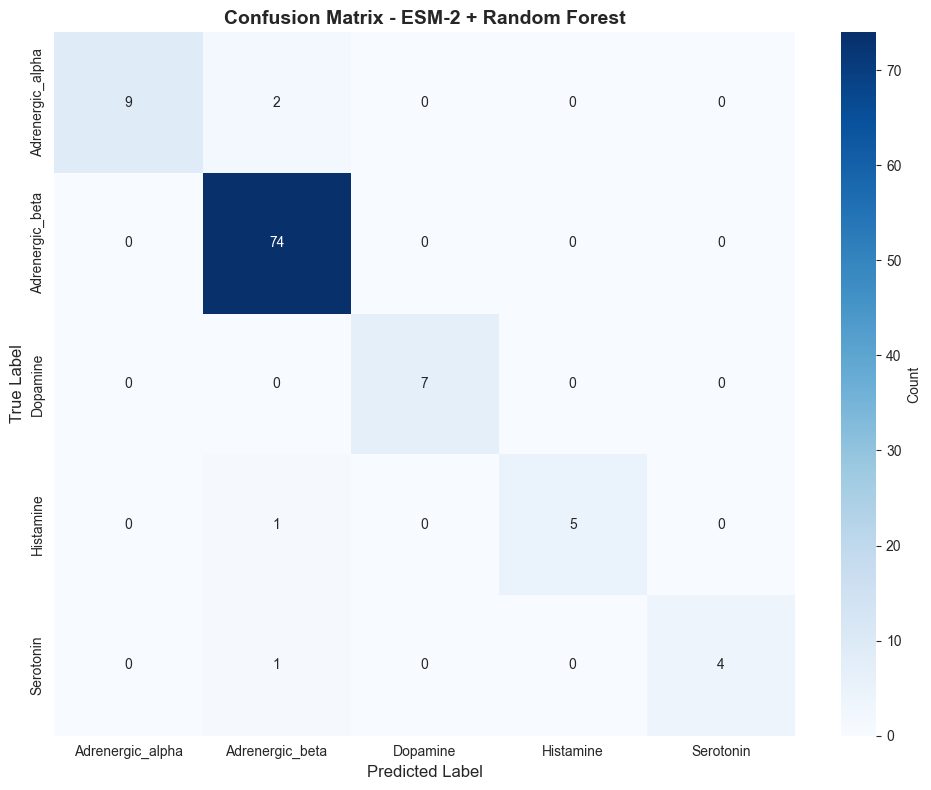


💾 Saved: ../results/figures/confusion_matrix.png

🔍 Top 10 Most Important Embedding Dimensions:
   1. Dimension 34: 0.0142
   2. Dimension 1120: 0.0134
   3. Dimension 1094: 0.0115
   4. Dimension 385: 0.0110
   5. Dimension 1115: 0.0106
   6. Dimension 849: 0.0101
   7. Dimension 990: 0.0099
   8. Dimension 1148: 0.0099
   9. Dimension 354: 0.0099
   10. Dimension 501: 0.0098


In [61]:
print("="*80)
print("📊 CLASSIFICATION REPORT")
print("="*80)
print()

# Detailed metrics per class
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix visualization
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - ESM-2 + Random Forest', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()

# Save
import os
os.makedirs('../results/figures', exist_ok=True)
plt.savefig('../results/figures/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n💾 Saved: ../results/figures/confusion_matrix.png")

# Feature importance (which embedding dimensions matter most?)
print(f"\n🔍 Top 10 Most Important Embedding Dimensions:")
importances = rf_clf.feature_importances_
top_indices = np.argsort(importances)[-10:][::-1]
for i, idx in enumerate(top_indices, 1):
    print(f"   {i}. Dimension {idx}: {importances[idx]:.4f}")

### 📈 How to Read the Confusion Matrix:

- **Diagonal** (top-left to bottom-right): Correct predictions ✅
- **Off-diagonal**: Mistakes ❌
- Example: If cell [Adrenergic_beta, Dopamine] = 5:
  - 5 Adrenergic_beta sequences were *incorrectly* predicted as Dopamine

---
## 9️⃣ Generate Embeddings - UNLABELED DATA

Now we apply the same embedding process to 'OtherClassA' sequences.

In [62]:
print("="*80)
print("🔄 GENERATING EMBEDDINGS - UNLABELED DATA")
print("="*80)

n_total = len(df_unlabeled)
print(f"\n📊 Processing {n_total} unlabeled sequences...\n")

embeddings_unlabeled = []
valid_unlabeled_indices = []
failed_unlabeled = 0

for i, (idx, row) in enumerate(df_unlabeled.iterrows()):
    try:
        sequence = row['sequence']
        embedding = get_embedding(sequence, model, batch_converter, device)
        
        embeddings_unlabeled.append(embedding)
        valid_unlabeled_indices.append(idx)
        
        if (i + 1) % 50 == 0 or (i + 1) == n_total:
            print(f"   Processed {i + 1}/{n_total} sequences")
        
    except Exception as e:
        failed_unlabeled += 1
        if failed_unlabeled <= 3:
            print(f"\n⚠️  Failed: {row.get('id', idx)} - {str(e)[:30]}")

embeddings_unlabeled_array = np.array(embeddings_unlabeled)
df_unlabeled_valid = df_unlabeled.loc[valid_unlabeled_indices].reset_index(drop=True)

print(f"\n✅ Complete")
print(f"   • Successful: {len(embeddings_unlabeled)} / {n_total}")
print(f"   • Failed: {failed_unlabeled}")
print(f"   • Shape: {embeddings_unlabeled_array.shape}")

🔄 GENERATING EMBEDDINGS - UNLABELED DATA

📊 Processing 1483 unlabeled sequences...

   Processed 50/1483 sequences
   Processed 100/1483 sequences
   Processed 150/1483 sequences
   Processed 200/1483 sequences
   Processed 250/1483 sequences
   Processed 300/1483 sequences
   Processed 350/1483 sequences
   Processed 400/1483 sequences
   Processed 450/1483 sequences
   Processed 500/1483 sequences
   Processed 550/1483 sequences
   Processed 600/1483 sequences
   Processed 650/1483 sequences
   Processed 700/1483 sequences
   Processed 750/1483 sequences
   Processed 800/1483 sequences
   Processed 850/1483 sequences
   Processed 900/1483 sequences
   Processed 950/1483 sequences
   Processed 1000/1483 sequences
   Processed 1050/1483 sequences
   Processed 1100/1483 sequences
   Processed 1150/1483 sequences
   Processed 1200/1483 sequences
   Processed 1250/1483 sequences
   Processed 1300/1483 sequences
   Processed 1350/1483 sequences
   Processed 1400/1483 sequences
   Processed

---
## 🔟 PREDICT SUBFAMILIES

### This is the main goal:
Take sequences labeled as 'OtherClassA' → Predict their true subfamily

In [63]:
print("="*80)
print("🎯 PREDICTING SUBFAMILIES")
print("="*80)

# Get predictions
y_pred_unlabeled = rf_clf.predict(embeddings_unlabeled_array)
y_pred_proba = rf_clf.predict_proba(embeddings_unlabeled_array)

# Convert back to subfamily names
predicted_subfamilies = le.inverse_transform(y_pred_unlabeled)

# Add to dataframe
df_unlabeled_valid['predicted_subfamily'] = predicted_subfamilies
df_unlabeled_valid['prediction_confidence'] = y_pred_proba.max(axis=1)

# Add probability for each class
for i, class_name in enumerate(le.classes_):
    df_unlabeled_valid[f'prob_{class_name}'] = y_pred_proba[:, i]

print(f"\n✅ Predictions Complete: {len(df_unlabeled_valid)} sequences")

# Distribution
print(f"\n📊 Predicted Subfamily Distribution:")
pred_counts = df_unlabeled_valid['predicted_subfamily'].value_counts()
for subfamily, count in pred_counts.items():
    pct = count / len(df_unlabeled_valid) * 100
    print(f"   • {subfamily}: {count} ({pct:.1f}%)")

# Confidence statistics
print(f"\n📈 Prediction Confidence:")
print(f"   • Mean: {df_unlabeled_valid['prediction_confidence'].mean():.3f}")
print(f"   • Median: {df_unlabeled_valid['prediction_confidence'].median():.3f}")
print(f"   • Min: {df_unlabeled_valid['prediction_confidence'].min():.3f}")
print(f"   • Max: {df_unlabeled_valid['prediction_confidence'].max():.3f}")

# High confidence predictions
high_conf = (df_unlabeled_valid['prediction_confidence'] > 0.8).sum()
print(f"\n✅ High confidence (>80%): {high_conf} / {len(df_unlabeled_valid)} ({high_conf/len(df_unlabeled_valid)*100:.1f}%)")

🎯 PREDICTING SUBFAMILIES

✅ Predictions Complete: 1483 sequences

📊 Predicted Subfamily Distribution:
   • Adrenergic_beta: 940 (63.4%)
   • Serotonin: 216 (14.6%)
   • Adrenergic_alpha: 212 (14.3%)
   • Dopamine: 71 (4.8%)
   • Histamine: 44 (3.0%)

📈 Prediction Confidence:
   • Mean: 0.590
   • Median: 0.514
   • Min: 0.237
   • Max: 1.000

✅ High confidence (>80%): 420 / 1483 (28.3%)


### 🎉 Success Criteria:

✅ **Good model** if:
- Predictions are **distributed** across multiple subfamilies (not just one!)
- Average confidence is **>0.7**
- Test accuracy was **>80%**

❌ **Problem** if:
- All predictions are the same subfamily → Model didn't learn properly
- Low confidence (<0.5) → Model is unsure
- Check earlier steps for issues

---
## 1️⃣1️⃣ Visualize Predictions

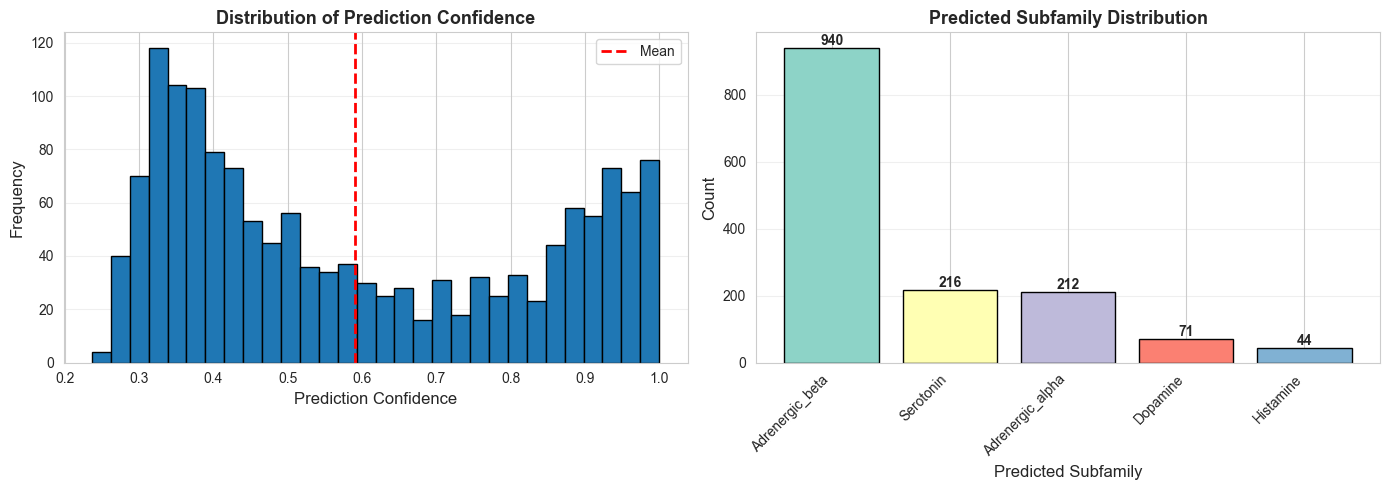


💾 Saved: ../results/figures/prediction_analysis.png


In [64]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confidence distribution
axes[0].hist(df_unlabeled_valid['prediction_confidence'], bins=30, edgecolor='black')
axes[0].axvline(df_unlabeled_valid['prediction_confidence'].mean(), 
                color='red', linestyle='--', label='Mean', linewidth=2)
axes[0].set_xlabel('Prediction Confidence', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Prediction Confidence', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Predicted classes
pred_counts = df_unlabeled_valid['predicted_subfamily'].value_counts()
colors = plt.cm.Set3(range(len(pred_counts)))
bars = axes[1].bar(range(len(pred_counts)), pred_counts.values, color=colors, edgecolor='black')
axes[1].set_xticks(range(len(pred_counts)))
axes[1].set_xticklabels(pred_counts.index, rotation=45, ha='right')
axes[1].set_xlabel('Predicted Subfamily', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_title('Predicted Subfamily Distribution', fontsize=13, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('../results/figures/prediction_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n💾 Saved: ../results/figures/prediction_analysis.png")

---
## 1️⃣2️⃣ Sample Predictions

In [65]:
print("="*80)
print("📋 SAMPLE PREDICTIONS")
print("="*80)

# Show diverse predictions
print("\n🔍 High Confidence Predictions:")
high_conf_samples = df_unlabeled_valid.nlargest(5, 'prediction_confidence')
for _, row in high_conf_samples.iterrows():
    seq_id = row.get('id', 'N/A')
    print(f"\n   ID: {seq_id}")
    print(f"   Predicted: {row['predicted_subfamily']} ({row['prediction_confidence']:.3f})")
    print(f"   Sequence: {row['sequence'][:60]}...")

print("\n" + "="*80)
print("⚠️  Low Confidence Predictions:")
low_conf_samples = df_unlabeled_valid.nsmallest(5, 'prediction_confidence')
for _, row in low_conf_samples.iterrows():
    seq_id = row.get('id', 'N/A')
    print(f"\n   ID: {seq_id}")
    print(f"   Predicted: {row['predicted_subfamily']} ({row['prediction_confidence']:.3f})")
    print(f"   Sequence: {row['sequence'][:60]}...")
    print(f"   Top 3 probabilities:")
    probs = {cls: row[f'prob_{cls}'] for cls in le.classes_}
    top3 = sorted(probs.items(), key=lambda x: -x[1])[:3]
    for cls, prob in top3:
        print(f"      • {cls}: {prob:.3f}")

📋 SAMPLE PREDICTIONS

🔍 High Confidence Predictions:

   ID: UniRef100_UPI00189D415B
   Predicted: Adrenergic_beta (1.000)
   Sequence: MGQPGNNSVFLLAPNGSHEPDHNVTQERDEAWVVGMGIVMSFIVLAIVFGNVLVITAIAR...

   ID: UniRef100_UPI001A9AFF86
   Predicted: Adrenergic_beta (1.000)
   Sequence: MGQPGNRSVFLLAPNASHAPDQDGTLERDEAWVVGMGILMSLIVLAIVFGNVLVITAIAK...

   ID: UniRef100_UPI0023028A11
   Predicted: Adrenergic_beta (1.000)
   Sequence: SLMPSTNGSSGNTSTVSEESWMVGLGIVMSLLVLAIVFGNVLVITAIARFQRLQTVTNYF...

   ID: UniRef100_UPI000462BC37
   Predicted: Adrenergic_beta (1.000)
   Sequence: ALSLNDSPSGGPTSGNATASEESWVVGMGILMSLIVLAIVFGNVLVITAIAKFQRLQTVT...

   ID: UniRef100_UPI00092E46F4
   Predicted: Adrenergic_beta (1.000)
   Sequence: NGSGLESANNNTVSGDVWMVGMGVLMSLIVLAIVFGNMLVITAIARFQRLQTVTNCFITS...

⚠️  Low Confidence Predictions:

   ID: UniRef100_A0A913Z6W9
   Predicted: Adrenergic_beta (0.237)
   Sequence: VLMGITLYAITVCSIVGNILVIVAVLTVRRLRSSITNYFIVSLACADLMVSMLVMPFAAV...
   Top 3 probabilities:
      • Adr

---
## 1️⃣3️⃣ Save Results

In [66]:
print("="*80)
print("💾 SAVING RESULTS")
print("="*80)

import joblib
import json

# Create directories
os.makedirs('../results', exist_ok=True)
os.makedirs('../models', exist_ok=True)

# 1. Save predictions
output_file = '../results/predicted_sequences.csv'
df_unlabeled_valid.to_csv(output_file, index=False)
print(f"\n✅ Predictions: {output_file}")

# 2. Save model
model_file = '../models/random_forest_classifier.pkl'
joblib.dump(rf_clf, model_file)
print(f"✅ Model: {model_file}")

# 3. Save label encoder
encoder_file = '../models/label_encoder.pkl'
joblib.dump(le, encoder_file)
print(f"✅ Encoder: {encoder_file}")

# 4. Save embeddings
np.save('../data/processed/embeddings_labeled.npy', embeddings_array)
np.save('../data/processed/embeddings_unlabeled.npy', embeddings_unlabeled_array)
print(f"✅ Embeddings: ../data/processed/embeddings_*.npy")

# 5. Save summary
summary = {
    'model': 'ESM-2 650M + Random Forest',
    'training': {
        'n_labeled_total': len(df_labeled),
        'n_labeled_valid': len(df_labeled_valid),
        'n_train': len(X_train),
        'n_test': len(X_test),
        'test_accuracy': float(accuracy),
        'classes': list(le.classes_)
    },
    'prediction': {
        'n_unlabeled_total': len(df_unlabeled),
        'n_unlabeled_valid': len(df_unlabeled_valid),
        'mean_confidence': float(df_unlabeled_valid['prediction_confidence'].mean()),
        'std_confidence': float(df_unlabeled_valid['prediction_confidence'].std()),
        'distribution': df_unlabeled_valid['predicted_subfamily'].value_counts().to_dict()
    },
    'parameters': {
        'embedding_dim': int(model.embed_dim),
        'n_estimators': 100,
        'class_weight': 'balanced'
    }
}

summary_file = '../results/prediction_summary.json'
with open(summary_file, 'w') as f:
    json.dump(summary, f, indent=2)
print(f"✅ Summary: {summary_file}")

print("\n" + "="*80)
print("🎉 PHASE 5 COMPLETE!")
print("="*80)
print(f"\n📊 Final Results:")
print(f"   • Test Accuracy: {accuracy*100:.2f}%")
print(f"   • Sequences Predicted: {len(df_unlabeled_valid)}")
print(f"   • Avg Confidence: {df_unlabeled_valid['prediction_confidence'].mean():.3f}")
print(f"\n📂 Output Files:")
print(f"   • {output_file}")
print(f"   • {model_file}")
print(f"   • {summary_file}")

💾 SAVING RESULTS

✅ Predictions: ../results/predicted_sequences.csv
✅ Model: ../models/random_forest_classifier.pkl
✅ Encoder: ../models/label_encoder.pkl
✅ Embeddings: ../data/processed/embeddings_*.npy
✅ Summary: ../results/prediction_summary.json

🎉 PHASE 5 COMPLETE!

📊 Final Results:
   • Test Accuracy: 96.12%
   • Sequences Predicted: 1483
   • Avg Confidence: 0.590

📂 Output Files:
   • ../results/predicted_sequences.csv
   • ../models/random_forest_classifier.pkl
   • ../results/prediction_summary.json


---
## 🎓 Summary & Next Steps

### What We Did:
1. ✅ Loaded full-length protein sequences
2. ✅ Generated ESM-2 embeddings (1280-dim vectors)
3. ✅ Trained Random Forest classifier with balanced classes
4. ✅ Predicted subfamilies for 'OtherClassA' sequences
5. ✅ Saved all results and models

### Key Files:
- **`predicted_sequences.csv`**: All predictions with confidence scores
- **`random_forest_classifier.pkl`**: Trained model (can reuse!)
- **`prediction_summary.json`**: Performance metrics

### If Results Look Bad:
1. **All predictions same class**:
   - Check if sequences are full-length (not tails!)
   - Verify multiple classes survived embedding generation
   - Try collecting more training data

2. **Low confidence**:
   - Sequences might be too divergent
   - Try different model (SVM, Neural Network)
   - Use deeper features (fine-tune ESM-2)

3. **High embedding failure rate**:
   - Confirm using `sequences_labeled_full.csv`
   - Remove gaps/invalid characters
   - Check sequence quality

### Next Steps:
1. Review predictions in `predicted_sequences.csv`
2. Manually validate high-confidence predictions
3. Use predictions for downstream analysis
4. Consider retraining with more data

---
**📧 Questions?** Check error messages above or review data quality.